In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import random


from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
data = np.genfromtxt('FATS_OGLE_bin.dat',
                     skip_header=1,
                     skip_footer=0,
                     encoding="utf-8",
                     names=True,
                     dtype=None,
                     delimiter='	')

df = pd.read_csv("FATS_OGLE_bin.dat", sep="	")
labels = list(df.columns.values)


df.head()

,Class,Amplitude,Std,Period,Mean,MaxSlope,Meanvariance,LinearTrend
0,1,6,6,5,17,15,3,11
1,1,3,3,7,18,22,2,10
2,1,4,3,6,18,44,2,11
3,1,2,2,5,9,1,2,10
4,1,2,2,5,15,35,1,11


In [4]:
# Metodo para testear 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    # Obtenida de https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    plt.show()
    return ax


# Naive bayes

### Explicacion metodo


Queremos estimar la probabilidad de una clase dado un set de features, que se traduce en:

$$ P(clase \mid features) $$

El metodo para predecir de Naive bayes se basa en el teorema de bayes, que dice


$$ P(clase \mid features) = \frac{P(features \mid clase) \, P(clase)}{P(features)} $$

Este metodo asume que cada feature de una dato para predecir una clase es independiente de los otros, por lo que podemos simplificar la expresion usando multiplicando las probabilidades independientes

$$ P(features \mid clase) =  P(feature_1 \mid clase)*P(feature_2 \mid clase)*\ldots*P(feature_n \mid clase)$$


La parte de abajo se puede eliminar porque es igual en todos los casos y nos quedamos solo con:

$$ P(clase \mid features) = P(feature_1 \mid clase)*P(feature_2 \mid clase)*\ldots*P(feature_n \mid clase)*P(Clase) $$


Entonces para calcular la probabilidad de una clase dado un set de features solo tenemos que obtener las probabilidades de que una feature este en una clase dada. Aqui viene la parte de entrenar el modelo (```fit```). Este metodo toma un set de datos de entrenamiento, que contiene muchos ejemplos de clases de estrellas (con los labels de las clases a las que pertenecen, junto a sus atributos)

### Fit

Para calcular las $P(feature_i \mid clase_j)$,  se pueden tomar 2 caminos (ambos estan con codigo abajo).
1. Asumir una distribucion normal para cada feature en la clase. ```GaussianNaiveBayes```
$$
feature_i \sim \mathcal{N}(\mu_{i, j},\,\sigma_{i,j}^{2})\,.
$$
    - Y vamos a obtener $\mu$ y $\sigma^{2}$ a partir de todos los ejemplos de la clase i.


2. Asumir que las features por clase vienen de una distribucion multinomial. Aqui se tendria que los datos tienen que ser categoricos. ```MultiomialnNaiveBayes```



Por ejemplo.
Tenemos en nuestro set de entrenamiento los siguientes datos

| Clase | Feature 1 | Feature 2 | Feature 3 | Feature 4 |
|-------|-----------|-----------|-----------|-----------|
| 0     | 23        | 43        | 15        | 4         |
| 1     | 24        | 42        | 16        | 5         |
| 1     | 22        | 40        | 12        | 6         |
| 0     | 26        | 39        | 23        | 3         |
| 1     | 22        | 40        | 22        | 3         |


y queremos la probabilidad de que un nuevo dato sea de la clase 1 vamos a tener que calcular lo siguiente:

$$ P(clase = 1 \mid {f_1 = 20, f_2 = 40, f_3 = 15, f_4 = 4}) = P(f_1 = 20 \mid clase = 1)*P(f_2 = 40 \mid clase = 1)*P( f_3 = 15 \mid clase = 1)*P(f_4 = 4 \mid clase = 1) $$

Como obtenemos las probabilidades del lado derecho? Con el set de entrenamiento. Por ejemplo para el feature 1, separamos los datos para cada clase.

#### Clase 0
| Clase | Feature 1 
|-------|-----------|
| 0     | 23        |
| 0     | 26        |

#### Clase 1
| Clase | Feature 1 
|-------|-----------|
| 1     | 24        |
| 1     | 22        |
| 1     | 22        |


Por ejemplo, asumimos que el feature 1 distribuye normal para cada clase, y usando los datos de entrenamiento, calculamos sus parametros

$$\text{Clase 0, feature 1  }  \mu =  24.5\;\;\sigma = 1.5$$
$$\text{Clase 1, feature 1  }  \mu =  22.7\;\;\sigma = 0.94$$

Si asumimos distribucion multinomial seria el conteo de cuantas features tienen una categoria dada/ total datos en esa clase.

$$\text{Clase 0, feature 1, categoria 1 (23), conteo = }1  $$
$$\text{Clase 0, feature 1, categoria 2 (26), conteo = }1$$
$$\text{Clase 1, feature 1, categoria 1 (24), conteo = }1  $$
$$\text{Clase 1, feature 1, categoria 2 (22), conteo = }2$$

y por ejemplo, la probabilidad en ambos casos queda:

$$P(y=1|X = \{22\}, D) = Normal(x = 22 | \mu =  22.7\;\;\sigma = 0.94)$$
$$P(y=1|X = \{22\}, D) = (2/3)$$
que es mas simple

Finalmente, solo queda calcular el termino $P(Y)$ que lo podemos asumir como igual para todos los casos, o sacar desde los datos, donde seria la cantidad de datos con clase y dividido en el total de datos


### Predict

Usando las distribuciones ya calculadas podemos ver la probabilidad de una clase dado un set de features

$$ P(clase \mid features) = P(feature_1 \mid clase)*P(feature_2 \mid clase)*\ldots*P(feature_n \mid clase)*P(clase) $$

$$ P(Y = y \mid X, D) = P(y)*\prod_{j=1}^{d}*P(x_j|D) $$


Donde $ P(feature_1 = feature_1test \mid clase) = P(x_j|D) $
Viene de la distribucion normal o la binomial en el caso correspondiente

Si queremos predecir una clase dado un set de features es solo cosa de probar con todas las clases posibles y ver cual tiene la mayor probabilidad.


### Gaussian Naive Bayes


Asumiendo distribuciones normales para cada feature en cada clase, con parametros obtenidos desde el set de datos

In [37]:
# Adaptado de https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/

class GaussianNaiveBayes():
    def __init__(self, labels):
        self.data = None
        self.X_train = None
        self.y_train = None
        self.summary = {}
        self.dict_clases = {}
        self.labels = labels
        self.classes = None
        self.contador_por_clase = {}
        
    def separate_data(self):
        """Separa data en features, classes, con train y test"""
        X = [] # Features
        y = [] # classes
        for i in self.data:
            y.append(i.tolist()[0])
            X.append(i.tolist()[1:])

        X = np.array(X)
        y = np.array(y)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.25, random_state=40, stratify=y)
        self.classes = set(self.y_train)
    
    def fit(self, data):
        self.data = data
        self.separate_data()
        self.group_by_class()
        self.summarize_data()
        # Este ultimo metodo arma un diccionario por clase de la forma {clase: {feature: {mean:mean, std:std}}}
        # Contiene toda la infomacion para hacer las predicciones
        
        
    
    def predict(self, test):
        """
        test {y:[clase],[variable 1]:[valor 1],. . . ,[variable n]:[valor n]}
        Retorna la probabilidad de la clase y
        """
        prob_total = 1
        clase = test['y']
        datos_clase = self.summary[clase]
        for feature_label in self.labels[1:]:
            if test[feature_label]: 
                # Si no es None
                # Calcula la probabilidad
                prob_total*= GaussianNaiveBayes.gaussian_probability(test[feature_label], datos_clase[feature_label]['mean'], datos_clase[feature_label]['stdev'])
        return prob_total*self.contador_por_clase[clase]
    
    def test_accuracy(self):
        """
        Usando los datos de X_test, y_test calcula % aciertos
        """
        # Primero armar diccionarios de tests
        n_tests = len(self.X_test)
        tests = []
        dict_base = {'y': 0, 
                    'Amplitude': 0,
                    'Std': 0,
                    'Period': 0,
                    'Mean': 0,  
                    'MaxSlope': 0,
                    'Meanvariance':  0,
                    'LinearTrend': 0}
        for i in range(n_tests):
            dict_test = {}
            dict_test['y'] = self.y_test[i]
            for indice_label in range(len(self.labels[1:])):
                dict_test[self.labels[indice_label + 1]] = self.X_test[i][indice_label]
            
            # Armar test en formato correcto
            tests.append(dict_test)
        
        
        guesses = []
        corrects = []
        cont_correctos = 0
        for test in tests:
            correct = test['y']
            corrects.append(correct)
            guess = self.get_class_prediction(test)
            guesses.append(guess)
            if correct == guess:
                cont_correctos += 1
                
        print(f"Gaussian naive bayes Score: {cont_correctos/n_tests}")
            
        cm = confusion_matrix(corrects, guesses)
        plot_confusion_matrix(cm, self.classes, normalize=True)
        
    

            
    
    def get_class_prediction(self, test):
        """
        test {[variable 1]:[valor 1],. . . ,[variable n]:[valor n]}
        Retorna clase que argmax
        """
        
        aux = test['y']
        probabilidades = {}
        for clase in self.classes:
            test['y'] = clase
            probabilidades[clase] = self.predict(test)
            
        test['y'] = aux
        
        return max(probabilidades, key=probabilidades.get)

    
    @staticmethod
    def mean(numbers):
        return sum(numbers)/float(len(numbers))
     
    @staticmethod
    def stdev(numbers):
        avg = GaussianNaiveBayes.mean(numbers)
        variance = sum([pow(x-avg,2) for x in numbers])/float(len(numbers)-1)
        return math.sqrt(variance)
    
    @staticmethod
    def gaussian_probability(x, mean, stdev):
        exponent = math.exp(-(math.pow(x-mean,2)/(2*math.pow(stdev,2))))
        return (1 / (math.sqrt(2*math.pi) * stdev)) * exponent
    
    def group_by_class(self):
        for i in self.classes:
            self.dict_clases[i] = []
            self.contador_por_clase[i] = 0

        
        
        total = 0
        for y, x in zip(self.y_train, self.X_train):
            self.dict_clases[y].append(x)
            self.contador_por_clase[y] += 1
            total += 1
        self.contador_por_clase = {key: value/total for key, value in self.contador_por_clase.items()}

        
    
    def summarize_data(self):
        """Toma los valores de X_train y saca mean y dv, agrupados por clase"""
        
        for clase in self.classes:
            # {clase: {feature: {mean:mean, std:std}}}
            self.summary[clase] = {}
            
            for indice_label in range(1, len(self.labels)):
                lista = [k[indice_label-1] for k in self.dict_clases[clase]]
                mean_label = GaussianNaiveBayes.mean(lista)
                dv_label = GaussianNaiveBayes.stdev(lista)
                self.summary[clase][self.labels[indice_label]] = {"mean": mean_label, "stdev": dv_label}
        

            

In [38]:
G_clf = GaussianNaiveBayes(labels)
G_clf.fit(data)



In [6]:
# Ejemplo de como se usan los metodos

test = {'y': 0, 
        'Amplitude': 11.758138711960369,
        'Std': 13.56758669497523,
        'Period': 16.47098372257608,
        'Mean': 7.255307855626327,  
        'MaxSlope': 9.357041755130927,
        'Meanvariance':  9.697452229299364,
        'LinearTrend': 10.499646142958245}
print(test['y'])
print(f"Clase predecida: " + str(G_clf.get_class_prediction(test)))
print(f'Probabilidad de que y={test["y"]}: {str(G_clf.predict(test))}')

0
Clase predecida: 0
Probabilidad de que y=0: 5.832550047232687e-09


Gaussian naive bayes Score: 0.8912046483608309


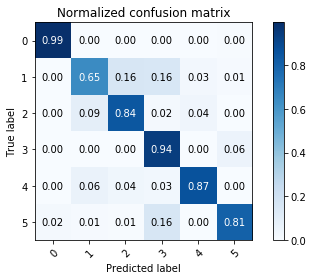

In [39]:
G_clf.test_accuracy()


### Multinomial Naive Bayes

Asumiendo que cada feature tiene clases fijas, con una distribucion categorica

La probabilidad total que buscamos queda:

$$ P(Y = y | X, D) \propto \frac{c_y}{n}\prod_{j=1}^d\frac{d_{j, y} (x_j)}{c_y}$$


- $C_y = $ conteo de ejemplos por clase $"y"$
- $n = $ total de ejemplos en set de entrenamiento
- $d_{j, y} (x_j) = $ conteo de ejemplos por feature $"j"$, categoria $x_j$

Entonces es la probabilidad de la clase y multiplicada por la probabilidad de que cada feature tome el valor $x_j$

In [5]:
class MultinomialNaiveBayes():
    
    def __init__(self, labels, test = False):
        self.labels = labels
        
        # Diccionario con categorias existentes para cada feature
        self.categories_labels = dict()
        
        
        # Para test del metodo
        self.test = test
        
        
        
        
        
    def separate_data(self):
        """Separa data en features, classes, con train y test"""
        X = [] # Features
        y = [] # classes
        
        X_total = []
        y_total = []
        
        
        conteos = [0 for i in range(6)]
        conteos[0] = 10000
        conteos[1] = 10000
        conteos[2] = 10
        conteos[3] = 100000
        conteos[4] = 10
        conteos[5] = 10
        for i in self.data:
            if not self.test:
                y.append(i.tolist()[0])
                X.append(i.tolist()[1:])
            elif self.test:
                # Solo para testeo de datos
                y_total.append(i.tolist()[0])
                X_total.append(i.tolist()[1:])
                
                if conteos[i.tolist()[0]] >= 0:
                    y.append(i.tolist()[0])
                    X.append(i.tolist()[1:])
                    conteos[i.tolist()[0]] = conteos[i.tolist()[0]] - 1 

        X = np.array(X)
        y = np.array(y)
        
        X_total = np.array(X_total)
        y_total = np.array(y_total)

        
        if not self.test:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.25, random_state=40, stratify=y)
        else:

            self.X_train, _, self.y_train, _ = train_test_split(X, y, test_size=0.25, random_state=40, stratify=y)
            
            _, self.X_test, _, self.y_test = train_test_split(X_total, y_total, test_size=0.25, random_state=40, stratify=y_total)
            
            
            
        self.classes = set(self.y_train)
        
        for i in range(len(self.labels[1:])):
            self.categories_labels[self.labels[i + 1]] = set()
            
            for cat in self.X_train[:, i]:
                self.categories_labels[self.labels[i + 1]].add(cat)
        
  
    def create_counts(self):
        """Hace los conteos de las distintas cosas que necesitamos"""
        
        # C
        self.c = {clase: 0 for clase in self.classes} #{clase_1: Numero}
        
        for dato in self.y_train:
            self.c[dato] += 1
            
        # n -> Numero de datos en total
        self.n = len(self.y_train)
        
        
        # d --> equivalente a betas
        self.d = {clase: {label: {l: 0 for l in range(100)} for label in self.labels[1:]} for clase in self.classes}
        
        for i in range(self.n):
            
            
            # Los valores de este dato
            aux = {self.labels[indice_label + 1]: self.X_train[i][indice_label] for indice_label in range(len(self.labels[1:]))}
            
            
            for label, categoria in aux.items():
                self.d[self.y_train[i]][label][categoria] += 1
                
    def predict(self, test):
        """
        test {y:[clase],[variable 1]:[valor 1],. . . ,[variable n]:[valor n]}
        Retorna la probabilidad de la clase y
        """
        clase = test['y']
        
        # self.n
        
        c_y = self.c[clase]
        
        
        prob_predictiva = (c_y)/(self.n)
        
        
        
        # Parte pitatoria
        for label in self.labels[1:]:
            
            try:
                d_yj = self.d[clase][label][test[label]]
            
            except KeyError:
                # Cuando la feature de la clase y ni tiene la categoria deseada
                return 0
            
            c_y = self.c[clase]
            
            prob_predictiva *= (d_yj)/(c_y)
            
        return prob_predictiva

            
    def test_accuracy(self):
        """
        Usando los datos de X_test, y_test calcula % aciertos
        """
        # Primero armar diccionarios de tests
        n_tests = len(self.X_test)
        tests = []
        dict_base = {'y': 0,
                     'Amplitude': 0,
                     'Std': 0,
                     'Period': 0,
                     'Mean': 0,
                     'MaxSlope': 0,
                     'Meanvariance':  0,
                     'LinearTrend': 0}
        for i in range(n_tests):
            dict_test = {}
            dict_test['y'] = self.y_test[i]
            for indice_label in range(len(self.labels[1:])):
                dict_test[self.labels[indice_label + 1]
                          ] = self.X_test[i][indice_label]

            # Armar test en formato correcto
            tests.append(dict_test)

        guesses = []
        corrects = []
        cont_correctos = 0
        for test in tests:
            correct = test['y']
            corrects.append(correct)
            guess = self.get_class_prediction(test)
            guesses.append(guess)
            if correct == guess:
                cont_correctos += 1

        print(f"Multinomial naive bayes Score: {cont_correctos/n_tests}")

        cm = confusion_matrix(corrects, guesses)
        plot_confusion_matrix(cm, self.classes, normalize=True, title="Normalized confusion matrix for Multinomial naive bayes")

    
    def get_class_prediction(self, test):
        """
        test {[variable 1]:[valor 1],. . . ,[variable n]:[valor n]}
        Retorna clase que argmax
        """
        
        aux = test['y']
        probabilidades = {}
        for clase in self.classes:
            test['y'] = clase
            probabilidades[clase] = self.predict(test)
            
        test['y'] = aux
        
        return max(probabilidades, key=probabilidades.get)

            
        
        
        
    def fit(self, data):
        self.data = data
        self.separate_data()
        self.create_counts()
        

In [6]:
M_clf = MultinomialNaiveBayes(labels)
M_clf.fit(data)



Multinomial naive bayes Score: 0.9047494121533648


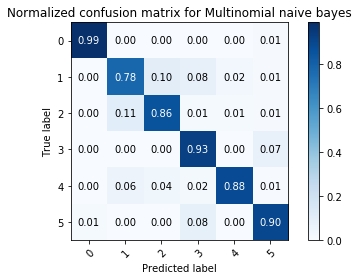

In [7]:
M_clf.test_accuracy()


### Comentarios Naive Bayes original


Como se puede ver con los scores de los 2 metodos, son bastante parecidos siendo un poco mejor (en este caso) el multinomial. 

Naive bayes original asume mucho de los datos, y con pocas muestras (o que esten sezgadas) esto puede generar problemas mas adelante.


Para probar esto, vamos a tomar de Data  ejemplos en mayoria de 3 clases (self.test = True en el codigo), y vamos a testear con todas las clases, donde no vamos a tener mucha informacion



(411671, 7) (411671,)
TEST
(102918, 7) (102918,)
Multinomial naive bayes Score: 0.7929128043685264


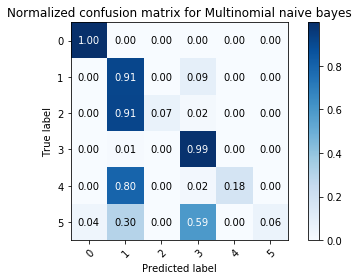

In [33]:
M_clf = MultinomialNaiveBayes(labels, True)
M_clf.fit(data)
M_clf.test_accuracy()


# Ejemplo donde se sacan la mayoria de los ejemplos para entrenamiento de las clases 0, 1, 3, 
# pero se testea con un total de ejemplos normal

# Bayesian naive bayes


El objetivo de este clasificador es el mismo que en los casos anteriores, predecir la clase de un dato dado distintos features.

$$ P(Y = y | X, D) $$

Donde $D$ son los datos anteriores (del set de entrenamiento)

$$D = \{(x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)\}$$
$$x_i = (x_{i1}, x_{i2}, \ldots, x_{id})$$
$$y_i \in \{1, 2, \ldots, m\}$$
Es decir, tenemos $n$ datos, con una componente $x$ con $d$ features (para los calculos asumi que cada clase de estas $d$ features $\in \{0, 1, 2, \ldots, N\}$ pero en el codigo hago uso de las solo las clases correspondientes, a pesar de tener un range(N)), y pertenecientes a una clase $y$


Ahora vamos a tener que calcular la posterior usando priors con un aproach bayesiano.

Separando los terminos, usando las leyes de las probabilidades tenemos que 

$$ P(Y = y | X, D)  = P(Y = y, X, D) = \int_\theta P(X, Y, D | \theta)*P(\theta)$$

Como todos los datos son independientes, el primer termino queda como 

$$ P(X, Y | \theta) $$
Que definiremos despues. Mientras que el segundo corresponde al prior de los parametros que tenemos. 
En este caso $\theta$ corresponde a los parametros de las distribuciones de las clases, y de las categorias de las features de cada dato. Para ser bayesianos tenemos que ponerle estas distribuciones.

### Primer termino
Nuestro objetivo es determinar el primer termino de la integral

$$ P(X, Y | \theta) $$

Primero tenemos que

$$ P(X, Y | \theta) = P(y|\theta)*P(X|Y, \theta) $$

Luego, usando la misma premisa de naive bayes original, que dice que cada feature de un dato es independiente, nos queda una multiplicacion sobre cada feature

$$ P(X, Y | \theta) = P(y|\theta)*P(X|Y, \theta) =  P(Y|\theta)*\prod_{j=1}^{d}P(X_j|y, \theta)$$

### Segundo termino

Primero, vamos a definir $\theta$, este es un vector que parametriza las distribuciones de los terminos $X_j$ y $Y$

Para Y tenemos:
$$P(Y|\theta) = \pi(Y)$$
Donde $\pi$ es un vector de probabilidades que tiene una distribucion categorica y 
$$\sum_y \pi(Y) = 1$$

Para $X_j$

$$P(X_j|Y, \theta) = r_{j, Y}(X_j)$$
Donde r es un vector de probabilidades que tambien tiene una distribucion categorica (es como el segundo caso que describi de naive bayes original).


En resumen, cada las clases de $Y$ dependen de los $\pi$ mientras que las clases de cada $X_j$ en una clase de Y, dependen de $r$ 

##### Parte bayesiana

Para ser bayesianos tenems que definir los priors de $\pi$ y $r$


Para $\pi$, como tenemos una distribucion categorica, vamos a poner una Dirichlet (que es la conjugada)
$$P(\pi) = Dir(\pi, \alpha) \propto \prod_{y=1}^m \pi(y)^{\alpha_y - 1}*I(\pi \;valid)$$

Entonces $\alpha$ es un vector de m dimensiones positivo que representa conteos a priori de cada clase.


Para $r_{j,k}$, que tambien tiene distribucion categorica, vamos a poner otra Dirichlet
$$P(\pi) = Dir(r_{j,k}, \beta) \propto \prod_{l=1}^N r_{j,k}(l)^{\beta - 1}*I(r_{j,k} \;valid)$$

Entonces $\beta$ es un vector de N dimensiones (una para cada categoria que puede tomar la feature j) positivo que representa conteos a priori de cada categoria en cada feature de una clase.


Si asumimos que $r_{j,k}$ y $\pi(y)$ son independientes, tenemos que 
$$P(\theta) = P(\pi)*\prod_j\prod_k P(r_{j,k})$$

Que es el segundo termino que buscabamos



## Continuacion posterior predictiva

Anteriormente teniamos
$$ P(Y = y | X, D) = \int_\theta P(X, Y, D | \theta)*P(\theta)$$

Reemplazando el primer y segundo termino de la integral por lo calculados anteriormente tenemos que:
$$ \int_\theta P(X, Y, D | \theta)*P(\theta) = \int_\theta  P(Y|\theta)*\prod_{j=1}^{d}P(X_j|y, \theta)*P(\pi)*\prod_j\prod_k P(r_{j,k})$$


Reagrupando, usando conteos en vez de $I(y=k)$ y reemplazando las distribuciones categoricas y Dirichlet (que son conjugadas y facilitan los calculos) nos quedamos con lo siguiente

$$ \int_\theta P(X, Y, D | \theta)*P(\theta) \propto (\int_\pi \pi(y)*Dir(\pi|\alpha+c_y)d\pi)\prod_{j, k}(\int_{r_{j,k}}r_{j, k}(x_j)^{I(y=k)}Dir(r_{j,k}|\beta + d_{j,k})dr_{j, k})$$

Donde tenemos dos integrales que son los valores esperados de las dirichlet, por lo que queda:

$$ \int_\theta P(X, Y, D | \theta)*P(\theta) \propto \frac{\alpha_y + c_y}{\alpha_0 + n}\prod_{j=1}^d\frac{\beta_{x, j} + d_{j, y} (x_j)}{\beta_0 + c_y}$$

Donde los terminos $d$ y $c$ corresponden a los conteos por categorias por clase y conteos de clases, respectivamente, mientras que $\alpha$ y $\beta$ son sus equivalentes del prior.

Entonces, para tener la probabilidad de que un vector X pertenezca a la clase y hay que calcular 
$$ P(Y = y | X, D) \propto \frac{\alpha_y + c_y}{\alpha_0 + n}\prod_{j=1}^d\frac{\beta_{x, j} + d_{j, y} (x_j)}{\beta_0 + c_y}$$

Donde cada termino significa:


- $C_y = $ conteo de ejemplos por clase $"y"$ (igual que en el caso no bayesiano)
- $\alpha_y$ conteo de ejemplos imaginarios (mi creencia de los datos) por clase $"y"$
- $\alpha_0$ es la sumatoria sobre todas las clases y de $\alpha_y$
- $n = $ total de ejemplos en set de entrenamiento (igual que en el caso no bayesiano)
- $d_{j, y} (x_j) = $ conteo de ejemplos por feature $"j"$, categoria $x_j$ en la clase $y$ (igual que en el caso no bayesiano)
- $\beta_{x, j} =$ conteo imaginario (mi creencia) de ejemplos por feature $"j"$, categoria $x_j$, en la clase $y$  
- $\beta_0 =$ Sumatoria de todos los conteos de categorias de una feature j, en la clase y



Algo interesante que hay que notar es que si nos damos los priors = 0, es decir no tenemos informacion de conteos previos, llegamos a la expresion

$$ P(Y = y | X, D) \propto \frac{c_y}{n}\prod_{j=1}^d\frac{d_{j, y} (x_j)}{c_y}$$
 Que es la que teniamos antes para el segundo caso (multinomial) de naive bayes.

 


In [8]:
class BayesianNaiveBayes():
    
    def __init__(self, labels):
        self.labels = labels
        
        # Diccionario con categorias existentes para cada feature
        self.categories_labels = dict()
        
        
        
        
        
    def separate_data(self):
        """Separa data en features, classes, con train y test"""
        X = [] # Features
        y = [] # classes
        for i in self.data:
            y.append(i.tolist()[0])
            X.append(i.tolist()[1:])

        X = np.array(X)
        y = np.array(y)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.25, random_state=40, stratify=y)
        self.classes = set(self.y_train)
        
        for i in range(len(self.labels[1:])):
            self.categories_labels[self.labels[i + 1]] = set()
            
            for cat in self.X_train[:, i]:
                self.categories_labels[self.labels[i + 1]].add(cat)
        
    def create_priors(self):
        
        # Primero los alphas
        
        
        # En realidad alpha deberia estar descrito a mano para cada clase, como no se mucho de los datos le voy a dar valores random
        ALPHA_PARAMETER = 1
        
        self.alphas = {clase: ALPHA_PARAMETER*random.randint(0, 30) for clase in self.classes}
        
        
        # Los betas
        
        # Matriz de num_clasesXnum_features
        # Para modelar mas facilmente despues, diccionario {0: {feature_1: {cat_1: conteo}, feature_2: {cat_1: conteo}}}
    
        # Nuevamente deberia estar modelado a mano para cada parametro
        BETA_PARAMETER = 1

        self.betas = {}
        for clase in self.classes:
            self.betas[clase] = {}
            
            for label in labels[1:]:
                conteos = {}
                
                for l in range(100):
                    conteos[l] = BETA_PARAMETER*random.randint(1, 30)
                
                self.betas[clase][label] = conteos
 
            
    def create_counts(self):
        """Hace los conteos de las distintas cosas que necesitamos"""
        
        # C
        self.c = {clase: 0 for clase in self.classes} #{clase_1: Numero}
        
        for dato in self.y_train:
            self.c[dato] += 1
            
        # n -> Numero de datos en total
        self.n = len(self.y_train)
        
        
        # d --> equivalente a betas
        self.d = {clase: {label: {l: 0 for l in range(100)} for label in self.labels[1:]} for clase in self.classes}
        
        for i in range(self.n):
            
            
            # Los valores de este dato
            aux = {self.labels[indice_label + 1]: self.X_train[i][indice_label] for indice_label in range(len(self.labels[1:]))}
            
            
            for label, categoria in aux.items():
                self.d[self.y_train[i]][label][categoria] += 1
                
    def predict(self, test):
        """
        test {y:[clase],[variable 1]:[valor 1],. . . ,[variable n]:[valor n]}
        Retorna la probabilidad de la clase y
        """
        clase = test['y']
        
        alpha_y = self.alphas[clase]
        alpha_0 = sum(self.alphas.values())
        
        # self.n
        
        c_y = self.c[clase]
        
        
        prob_predictiva = (alpha_y + c_y)/(alpha_0 + self.n)
        
        
        
        # Parte pitatoria
        for label in self.labels[1:]:
            
            
            B_xj = self.betas[clase][label][test[label]]

            
            d_yj = self.d[clase][label][test[label]]
            
            B_0 = sum(self.betas[clase][label].values())
            
            c_y = self.c[clase]
            
            prob_predictiva *= (B_xj + d_yj)/(B_0 + c_y)
            
        return prob_predictiva

            
    def test_accuracy(self):
        """
        Usando los datos de X_test, y_test calcula % aciertos
        """
        # Primero armar diccionarios de tests
        n_tests = len(self.X_test)
        tests = []
        dict_base = {'y': 0,
                     'Amplitude': 0,
                     'Std': 0,
                     'Period': 0,
                     'Mean': 0,
                     'MaxSlope': 0,
                     'Meanvariance':  0,
                     'LinearTrend': 0}
        for i in range(n_tests):
            dict_test = {}
            dict_test['y'] = self.y_test[i]
            for indice_label in range(len(self.labels[1:])):
                dict_test[self.labels[indice_label + 1]
                          ] = self.X_test[i][indice_label]

            # Armar test en formato correcto
            tests.append(dict_test)

        guesses = []
        corrects = []
        cont_correctos = 0
        for test in tests:
            correct = test['y']
            corrects.append(correct)
            guess = self.get_class_prediction(test)
            guesses.append(guess)
            if correct == guess:
                cont_correctos += 1

        print(f"Multinomial naive bayes Score: {cont_correctos/n_tests}")

        cm = confusion_matrix(corrects, guesses)
        plot_confusion_matrix(cm, self.classes, normalize=True, title="Normalized confusion matrix for Multinomial naive bayes")
        
            
            
            
    
    def get_class_prediction(self, test):
        """
        test {[variable 1]:[valor 1],. . . ,[variable n]:[valor n]}
        Retorna clase que argmax
        """
        
        aux = test['y']
        probabilidades = {}
        for clase in self.classes:
            test['y'] = clase
            probabilidades[clase] = self.predict(test)
            
        test['y'] = aux
        
        return max(probabilidades, key=probabilidades.get)

        
    def fit(self, data):
        self.data = data
        self.separate_data()
        self.create_priors()
        self.create_counts()
        

In [14]:
# B_clf = BayesianNaiveBayes(labels)

# B_clf.fit(data)

data

array([(1, 3, 3,  7, 18, 22, 2, 10), (1, 4, 3,  6, 18, 44, 2, 11),
       (1, 2, 2,  5,  9,  1, 2, 10), ..., (3, 1, 1, 11,  6,  4, 1, 11),
       (3, 1, 1,  4,  5, 32, 1, 10), (3, 1, 1, 12,  5,  1, 1, 10)],
      dtype=[('1', '<i4'), ('6', '<i4'), ('6_1', '<i4'), ('5', '<i4'), ('17', '<i4'), ('15', '<i4'), ('3', '<i4'), ('11', '<i4')])

Multinomial naive bayes Score: 0.9045745156338055


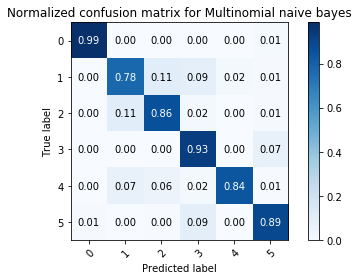

In [36]:
B_clf.test_accuracy()

## Analisis bayesian naive bayes


Al igual que en el ejemplo de clases donde calculamos la posterior predictiva para el lanzamiento de una moneda, se puede ver que a la formula final solo se le agreagn parametros que representan mis creencias de los datos.

En este caso no pude hacer que mejorara mucho el score con el set de training ya que no tengo mucha informacion a priori de estos, pero variando los valores de $\alpha$ y $\beta$, cambian algunas predicciones. Ahora estos valores se fijan con un random en la funcion create_priors

Si fijamos $\alpha = 0$ y $\beta = 0$, que arriba dije que corresponde al naive bayes multinomial original, vemos que se obtiene el mismo score.





#### Robustez frente a menos datos
Si vemos el mismo ejemplo que en multinomial naive bayes, con menos ejemplos en las clases 2, 4, 5, teniendo un buen prior para cada variable podriamos ver una buena matriz de confusion, ya que los valores de $\alpha$ y $\beta$ ayudarian a tomar decisiones para clases donde no tengo mucha informacion de los datos. Esto tambien sirve para el otro lado, si llego a tener muchos datos, los terminos del prior no van a aportar mucho para la desicion de la clase